In [1]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from mpl_toolkits.axes_grid1 import ImageGrid
from scipy.io import loadmat
from scipy.optimize import fmin_cg

# Exercise 3.1: Logistic Regression (dimension-400, power-1, category-10, regularised)
---

In exercise-2 we look at logistic regression to categorise 2D data with binary labels. In one example the two categories are separable by a flat boundary surface, so being a power-1 problem, and in another example the two categories require a curved boundary surface, which we solve by using up to and including power-6 features. All categorisation problems can, in fact, actually be cast as binary problems, as we can always take one specific category of interest and have all other categories that may be present grouped together as "other". We can therefore determine as many boundary surfaces as there are categories of data, each separating one specific category from all others, and then, for some new and unlabelled data points, select their label by whatever boundary surface provides the highest raw sigmoid score (i.e. not the score rounded to a pure 0 or 1, as this would not be distinct enough from one category to the next). That's exactly what we do in this exercise.

The data set used herein is a set of handwritten digit images from an MNIST challenge. At first glance this may seem to be a 3D problem, as we have 2D images with a variable greyscale value in a third dimension, and with each example having a label 1 to 10 (where label 10 is for digit 0, which was beneficial for Andrew to do for Octave indexing reasons). However, a full single image is a single data point, and a single data point must have only one value for each dimension that will be used to cast the problem, in order to establish its unique location in data-space. As there are as many 3D image-position-plus-greyscale coordinates as there are pixels for any given image, these coordinates are hence not suitable as a data-space. Instead, we must consider each pixel as a distinct dimension, with the pixel's greyscale value being the position along that dimension, so to speak, and we therefore have the required one-value-per-dimension description for an image as a whole. The given images are 20 $\times$ 20 pixels in size, which gives a 400D data-space. We won't take any higher powers of these values in making further features, so this is a power-1 problem, meaning that a "flat" boundary surface is sought for each logistic regression classifier that will be trained.

The basic method and cost function are exactly the same as in exercise-2. And again, instead of manual gradient descent, we use an automated optimiser function. But whereas in exercise-2 we used ``fmin_bfgs``, here we use ``fmin_cg``, although I'm not sure what the differences are, they both seem to do the same job as far as this work is concerned. Just following Andrew's lead. Let's begin by having a look at the data, first just a single image (a single data point, remember), and then a group of images selected at random. Note that the two sets of four images shown below are just included to illustrate the use of ``ImageGrid``, and the benefits that has over simply using ``subplot``:

In [2]:
d1 = loadmat('ex3/ex3data1.mat')
d1.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [43]:
d1_X = d1['X']
d1_X.shape

(5000, 400)

In [44]:
d1_y = d1['y']
d1_y.shape

(5000, 1)

In [30]:
plt.gray() # I think this sets output to greyscale for all plots from now on

<Figure size 432x288 with 0 Axes>

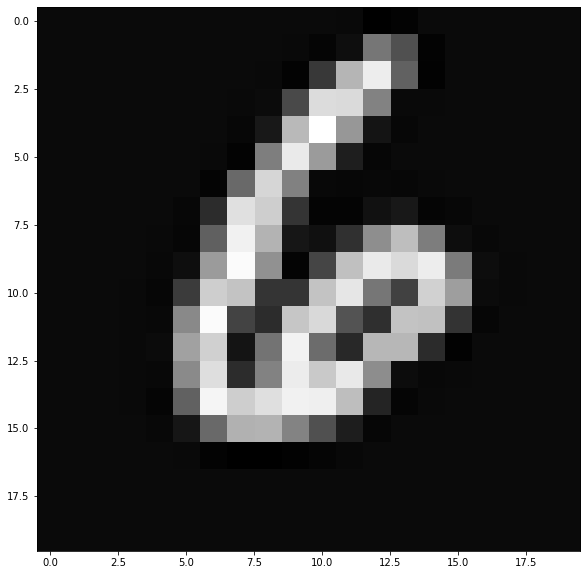

In [6]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
im = np.transpose(np.reshape(d1_X[3000], [20,20]))
ax.imshow(im)
plt.show()

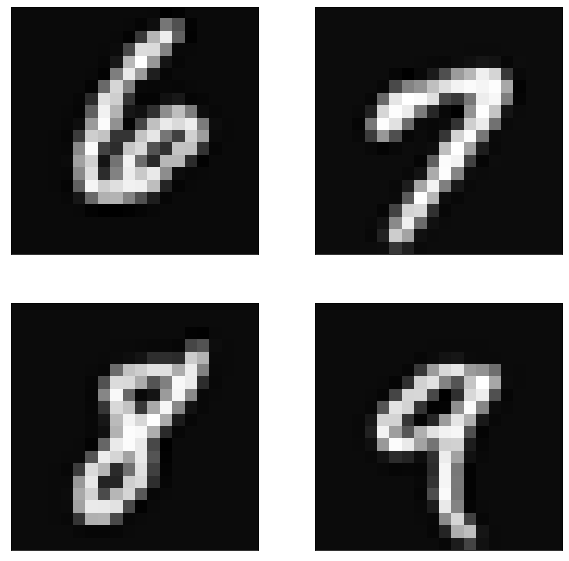

In [7]:
fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(10,10))

im1 = np.transpose(np.reshape(d1_X[3000], [20,20]))
im2 = np.transpose(np.reshape(d1_X[3500], [20,20]))
im3 = np.transpose(np.reshape(d1_X[4000], [20,20]))
im4 = np.transpose(np.reshape(d1_X[4500], [20,20]))

for ax,im in zip([ax1,ax2,ax3,ax4], [im1,im2,im3,im4]):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(im)

plt.show()

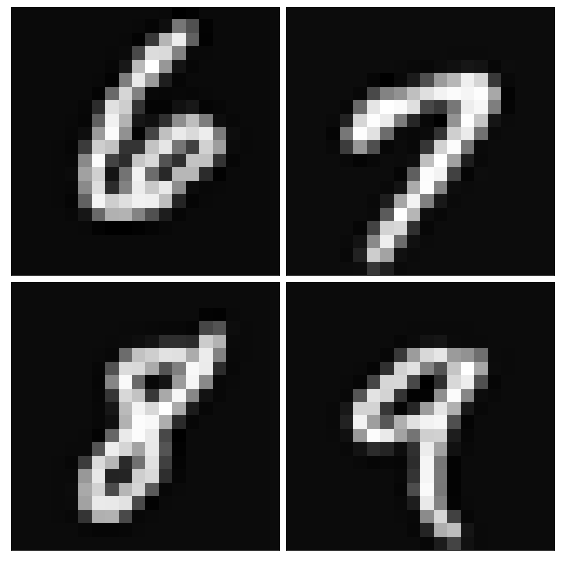

In [8]:
fig = plt.figure(figsize=(10,10))

axs = ImageGrid(
    fig,
    111, # Similar to subplot(111)
    nrows_ncols = (2,2),
    axes_pad = 0.1, # Pad between axes in inches
)

ims = [
    np.transpose(np.reshape(d1_X[3000], [20,20])),
    np.transpose(np.reshape(d1_X[3500], [20,20])),
    np.transpose(np.reshape(d1_X[4000], [20,20])),
    np.transpose(np.reshape(d1_X[4500], [20,20])),
]

for ax,im in zip(axs, ims):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(im)

plt.show()

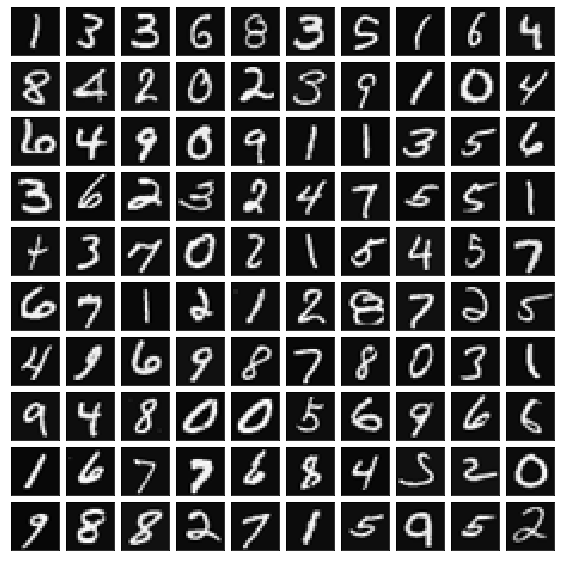

In [37]:
fig = plt.figure(figsize=(10,10))

axs = ImageGrid(
    fig,
    111,
    nrows_ncols = (10,10),
    axes_pad = 0.1,
)

ims = [
    np.transpose(np.reshape(d1_X[exs_idx], [20,20]))
    for exs_idx in np.random.choice(d1_X.shape[0], 100, replace=False)
]

for ax,im in zip(axs, ims):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(im)

plt.show()

---

Let's make a function to include an offset term via the dummy feature $x_0 = 1$:

In [10]:
def add_ones(X):
    return(np.append(np.ones([X.shape[0],1]), X, axis=1))

In [11]:
d1_X_ones = add_ones(d1_X)
d1_X_ones.shape

(5000, 401)

---

Now define the sigmoid function and the cost function and test:

In [12]:
def sigmoid(g):
    return(1 / (1 + np.exp(-g)))

In [13]:
def get_cost(
    theta,
    lamb,
    X,
    y,
    get_derivative=True,
):

    if (theta.ndim == 1):
        theta = np.transpose([theta])

    m = X.shape[0]
    g = np.dot(X, theta)
    h = sigmoid(g) # These are the predictions for the y values we're trying to match i.e. h is an array of the same size as y
    h_minus_y = h - y

    cost = \
          (-1 / m) \
        * np.sum((y * np.log(h)) + ((1-y) * np.log(1-h))) \
        + (lamb / (2 * m)) * np.sum(np.power(theta[1:], 2))

    if (not get_derivative):
        return(cost)
    else:
        dcost_by_dtheta = (1 / m) * np.dot(np.transpose(X), h_minus_y)
        dcost_by_dtheta[1:] += (lamb / m) * theta[1:]
        return(cost, dcost_by_dtheta)

In [14]:
def get_theta(
    theta_init,
    lamb,
    iters_num,
    X,
    y,
    disp=True,
):

    theta = fmin_cg(
        get_cost,
        theta_init,
        args=(
            lamb,
            X,
            y,
            False,
        ),
        maxiter=iters_num,
        disp=disp,
    )

    theta = np.transpose([theta])

    return(theta)

In [15]:
test_X = np.transpose(np.reshape(np.arange(1,16)/10, [3,5]))
test_X_ones = add_ones(test_X)
test_y = np.transpose([[1,0,1,0,1]])

test_cost, test_dcost_by_dtheta = get_cost(
    np.transpose([[-2.0,-1.0,1.0,2.0]]),
    3,
    test_X_ones,
    test_y,
)
print(test_cost)
print(test_dcost_by_dtheta)
# 2.534819396109744
# [[ 0.14656137]
#  [-0.54855841]
#  [ 0.72472227]
#  [ 1.39800296]]

2.534819396109744
[[ 0.14656137]
 [-0.54855841]
 [ 0.72472227]
 [ 1.39800296]]


---

Run the optimisation function to find the optimum $\overrightarrow{\theta}$ for a regularised sigmoid fit, one for each category. Note that digit label 1 is in the Python index 0 position, on up to digit label 10 which is in the Python index 9 position, with digit label 10 corresponding to actual digit 0, remember. When calculating predicted labels, we then take the Python index of the highest sigmoid-scoring set of parameters and add 1. This is done for consistency with the following section on neural networks. Also note that this took about 5-6 mins per digit, so about 50 mins total, when I used a Pandas-Numpy combination, but takes only 30-40 secs per digit, so about 4 mins total, with just a pure Numpy implementation:

In [21]:
cats = range(1,11)
d1_theta = np.zeros([d1_X_ones.shape[1], len(cats)])

time_start_all = datetime.now()

for cats_idx,cat in enumerate(cats):

    print(f'Cat: {0 if (cat==10) else cat}')

    d1_y_cat = np.array([[0]] * d1_X_ones.shape[0])
    d1_y_cat[np.where(d1_y == cat)] = 1

    time_start = datetime.now()
    d1_theta[:,cats_idx] = get_theta(
        np.array([[0.0]] * d1_X_ones.shape[1]),
        0.1,
        10,
        d1_X_ones,
        d1_y_cat,
    ).transpose()
    time_end = datetime.now()

    deltat = time_end - time_start
    deltat_secs = round(deltat.seconds + (deltat.microseconds / 1e6), 6)
    deltat_mins = round(deltat_secs / 60, 6)

    print(f'Time taken: {deltat_secs} secs')
    print(f'Time taken: {deltat_mins} mins')
    print()

time_end_all = datetime.now()

deltat = time_end_all - time_start_all
deltat_secs = round(deltat.seconds + (deltat.microseconds / 1e6), 6)
deltat_mins = round(deltat_secs / 60, 6)

print('All cats:')
print(f'Time taken: {deltat_secs} secs')
print(f'Time taken: {deltat_mins} mins')

print(d1_theta.shape)

Cat: 1
         Current function value: 0.029300
         Iterations: 10
         Function evaluations: 11687
         Gradient evaluations: 29
Time taken: 24.215226 secs
Time taken: 0.403587 mins

Cat: 2
         Current function value: 0.084478
         Iterations: 10
         Function evaluations: 10478
         Gradient evaluations: 26
Time taken: 20.232253 secs
Time taken: 0.337204 mins

Cat: 3
         Current function value: 0.083454
         Iterations: 10
         Function evaluations: 11284
         Gradient evaluations: 28
Time taken: 21.746541 secs
Time taken: 0.362442 mins

Cat: 4
         Current function value: 0.060838
         Iterations: 10
         Function evaluations: 10881
         Gradient evaluations: 27
Time taken: 19.79431 secs
Time taken: 0.329905 mins

Cat: 5
         Current function value: 0.114597
         Iterations: 10
         Function evaluations: 8463
         Gradient evaluations: 21
Time taken: 20.685948 secs
Time taken: 0.344766 mins

Cat: 6
     

---

Let's compare all predictions for the given data set itself, and compare with the known labels to get an overall accuracy score:

In [22]:
d1_predictions = np.transpose([np.argmax(sigmoid(np.dot(d1_X_ones, d1_theta)), axis=1)])
d1_predictions += 1
d1_accuracy = np.mean(d1_y == d1_predictions)
d1_accuracy
# 0.9072

0.9072

# Exercise 3.2: Neural Network (dimension-400, power-1, category-10, (un)regularised???)
---

Now for something completely different. Until now we have sought a single set of parameters to map some input vector to some output value, both in linear regression and logistic regression problems. The parameters have described how the change in position in any one dimension correlates with a change in the output value, such as given by the gradient of a straight line in the simplest case. The next step of complexity, and also of capability, comes by producing multiple intermediate output values for a given input vector, thereby forming a vector in and of themselves, and using that as the input to a subsequent layer to calculate further parameters. In effect, this gives us various mixtures of various starting features, and in principle there's no limit to the number of intermediate layers, or the number of final output values, that we have. Typically, though, the final layer of processing ends with a number of discreet output category options, and is just the same as the one-versus-all logistic regression classifier seen above. In essence, the features that make up the input to the final layer are themselves learnt in the preceding layers, as opposed to what we have done previously, which has been to manually specify the features ahead of time. This multi-layer approach is referred to as a "_neural network_".

Here we observe some parameters for a 2-layer network, so having a single intermediate stage between initial input and final output. These parameters were given by training on the same MNIST digit data as used above. By multiplying through the already prepared input data and applying the sigmoid function at each layer stage, we again come to a set of sigmoid scores for each data example and each category, and can take the highest sigmoid-scoring category for each example as its predicted label. Again, as in exercise-3.1, note that digit label 1 is in the Python index 0 position, on up to digit label 10 which is in the Python index 9 position, with digit label 10 corresponding to actual digit 0, remember. When calculating predicted labels, we then take the Python index of the highest sigmoid-scoring set of parameters and add 1:

In [23]:
d1_thetas_nn = loadmat('ex3/ex3weights.mat')
d1_thetas_nn.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Theta1', 'Theta2'])

In [24]:
d1_thetas_nn['Theta1'].shape

(25, 401)

In [31]:
d1_thetas_nn['Theta1'] = np.transpose(d1_thetas_nn['Theta1'])
d1_thetas_nn['Theta1'].shape

(401, 25)

In [25]:
d1_thetas_nn['Theta2'].shape

(10, 26)

In [32]:
d1_thetas_nn['Theta2'] = np.transpose(d1_thetas_nn['Theta2'])
d1_thetas_nn['Theta2'].shape

(26, 10)

In [38]:
d1_g1 = np.dot(d1_X_ones, d1_thetas_nn['Theta1'])
d1_g1.shape

(5000, 25)

In [39]:
d1_h1 = sigmoid(d1_g1)
d1_h1.shape

(5000, 25)

In [34]:
d1_h1_ones = add_ones(d1_h1)
d1_h1_ones.shape

(5000, 26)

In [40]:
d1_g2 = np.dot(d1_h1_ones, d1_thetas_nn['Theta2'])
d1_g2.shape

(5000, 10)

In [41]:
d1_h2 = sigmoid(d1_g2)
d1_h2.shape

(5000, 10)

In [42]:
d1_predictions = np.transpose([np.argmax(d1_h2, axis=1)])
d1_predictions += 1
d1_accuracy = np.mean(d1_y == d1_predictions)
d1_accuracy
# 0.9752

0.9752

Even though the one-vs-all logisitic regression classifier did a pretty good job in terms of accuracy, we see a clear improvement here with the neural network approach. In exercise-4 we actually train these neural network parameters ourselves.